### Load the required packages used in this project. 

In [1]:
library(httr)
library(lubridate)
library(jsonlite)
library(dplyr)
library(ggplot2)
library(tidyr)
library(data.table)
library(gridExtra)
options(stringsAsFactors = F)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



### First we need to load that beautiful, sexy data.

In [2]:
page_data <- read.csv('page_data.csv')
# need fread to automatically delete the first two rows
population <- fread('Population Mid-2015.csv') 

### In order to obtain article quality predictions from ORES, we first need to subset the articles into 75 unit chunks in order to speed up the process of predicting article quality. 

In [3]:
# create a list of 75 rev_ids at a time
sub_list <- list()
t=1
i=1
z=75
end <- round(length(page_data$rev_id)/z)+1
for(j in 1:end){
  sub_list[[t]] <- page_data$rev_id[i:z]
  i=i+75
  z=z+75
  t=t+1
}

### Now that we have 75 unit chunks of article ids, we can ping the API getting predictions on those 75 articles at once.

In [4]:
# get ORES data from API
get.ores.data <- function(rev_ids){
    # this function takes article ids and returns the predicted article quality
    # by running it through the ORES machine learning algorithm
  ores_list <- list()
  endpoint_raw <- 'https://ores.wikimedia.org/v3/scores/enwiki/?models=wp10&revids='
  for(begin in 1:end){
    revids <- paste(na.omit(sub_list[[begin]]), collapse='|')
    endpoint <- paste0(endpoint_raw, revids)
    raw.data <- GET(endpoint)
    raw.content <- rawToChar(raw.data$content)
    parsed.data <- fromJSON(raw.content)
    ores_list[[begin]] <- parsed.data
  }
  return(ores_list)
}
# ping the API by running this function on the subset list created above
ores_list <- get.ores.data(sub_list)

### Now that we have the raw data from the API, we need to extract the relevant information that we need, namely the articles and their predicted quality. 

In [5]:
a=1
ids <- c()
preds <- c()
for(i in 1:length(ores_list)){
  for(j in 1:length(ores_list[[i]]$enwiki$scores)){
    ids[a] <- names(ores_list[[i]]$enwiki$scores[j])
    # one of the predictions was NULL so include this conditional to allow the loop to run
    if(is.null(ores_list[[i]]$enwiki$scores[j][[1]][[1]][[1]]$prediction[1])){
      preds[a] <- NA
    }
    else{
      preds[a] <- ores_list[[i]]$enwiki$scores[j][[1]][[1]][[1]]$prediction[1]
    }
    a=a+1
  }
}

### The next step is to merge the data loaded in the first step with the data from the API. The data is merged on the country in order to create a dataframe with the country, the population, and the predicted article quality for each article. 
#### Following the merge, we must create a final data frame.

In [6]:
# merge the data
population_formerge <- population[,-c(2:4,6)]
sub_merge <- merge(page_data, population_formerge, by.x = 'country', by.y = 'Location', all=F)
names(sub_merge)[4] <- 'population'

temp_df <- data.frame('ids'=ids, 'predictions'=preds)
final_merge <- merge(sub_merge, temp_df, by.x = 'rev_id', by.y = 'ids', all = F)

# create final dataframe

names(final_merge) <- c('revision_id', 'country', 'article_name', 'population', 'article_quality')
final_merge <- na.omit(final_merge[,c(2,3,1,5,4)])
write.csv(final_merge, file='final_data.csv', row.names=F)

In [7]:
final_merge <- transform(final_merge, country = factor(country),
                        article_quality = factor(article_quality))

### In order to complete the required analysis, the final_merge dataframe must be transformed using the group by function within the dplyr package. We group by the country and compute a number of metrics for subsequent visualization. 

In [9]:
total_articles <- final_merge %>%
  group_by(country) %>%
  summarise('total_articles'= as.numeric(length(page)),
            'population'= (unique(population)),
            'FA'= sum(article_quality == 'FA'),
            'GA' = sum(article_quality == 'GA'),
            'total_high' = (FA + GA))
total_articles <- as.data.frame(total_articles)
total_articles$population <- as.numeric(gsub(total_articles$population, 
                                             pattern = ',', replacement = ''))
total_articles$perpop <- with(total_articles, total_articles/population)*100
total_articles$percenthigh <- with(total_articles, total_high/population * 100)

### Once the summary table has been created we make four plots summarizing the data for various factors that were chosen by people much smarter than I who are more versed, accomplished, and generally all around better human beings. 

pdf 
  2

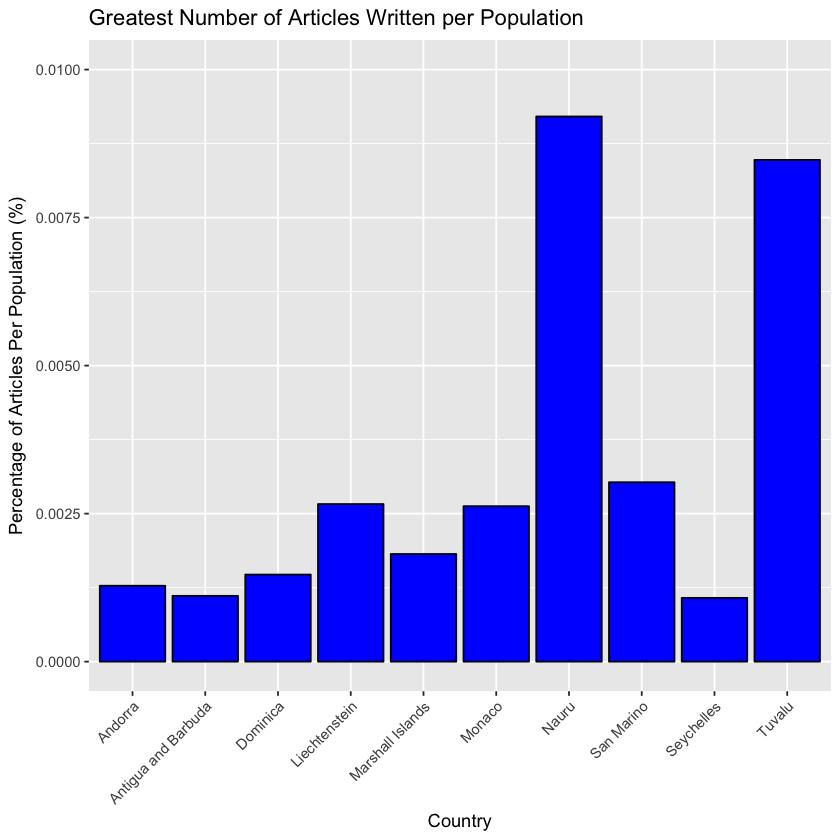

In [10]:
high_articles_plot <- ggplot(head(total_articles[order(total_articles$perpop, 
                                                       decreasing = T),],10), 
                             aes(country, perpop)) +
  geom_bar(stat = 'identity', color = 'black', fill='blue') +
  ylab('Percentage of Articles Per Population (%)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0,0.01)) +
  ggtitle('Greatest Number of Articles Written per Population') +
  xlab('Country')
png(file = 'high_article_percent.png')
plot(high_articles_plot)
dev.off()
high_articles_plot

pdf 
  2

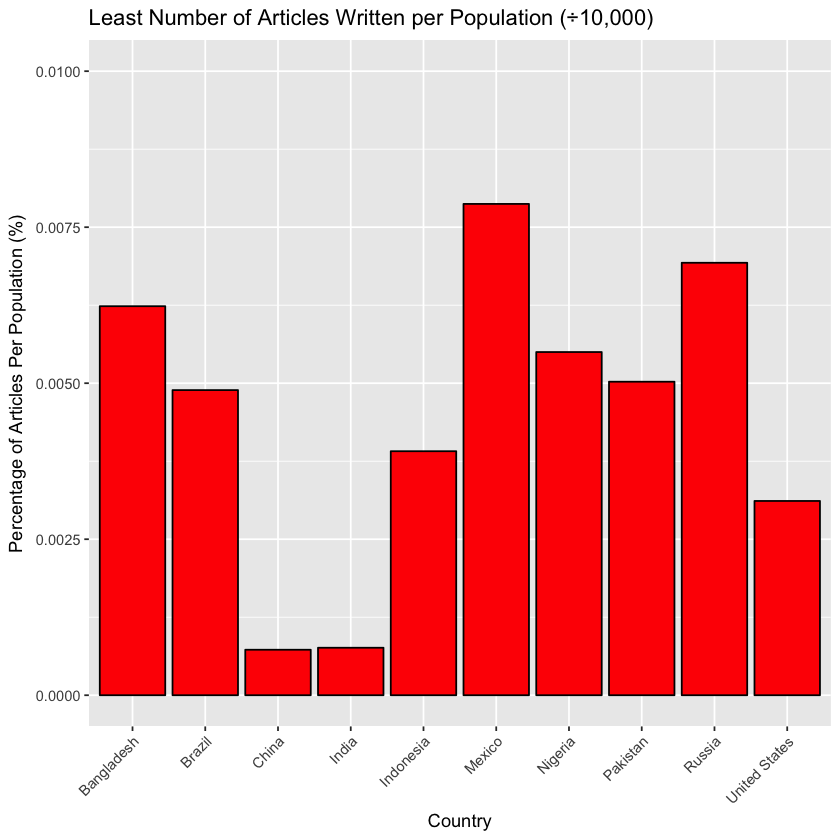

In [11]:
low_articles_plot <- ggplot(tail(total_articles[order(total_articles$perpop, 
                                                       decreasing = T),],10), 
                             aes(country, (perpop*10000))) +
  geom_bar(stat = 'identity', color = 'black', fill='red') +
  ylab('Percentage of Articles Per Population (%)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0,0.01)) +
  ggtitle('Least Number of Articles Written per Population (÷10,000)') +
  xlab('Country')
png(file = 'low_article_percent.png')
plot(low_articles_plot)
dev.off()
low_articles_plot

Warning message:
“Removed 1 rows containing missing values (position_stack).”

pdf 
  2

Warning message:
“Removed 1 rows containing missing values (position_stack).”

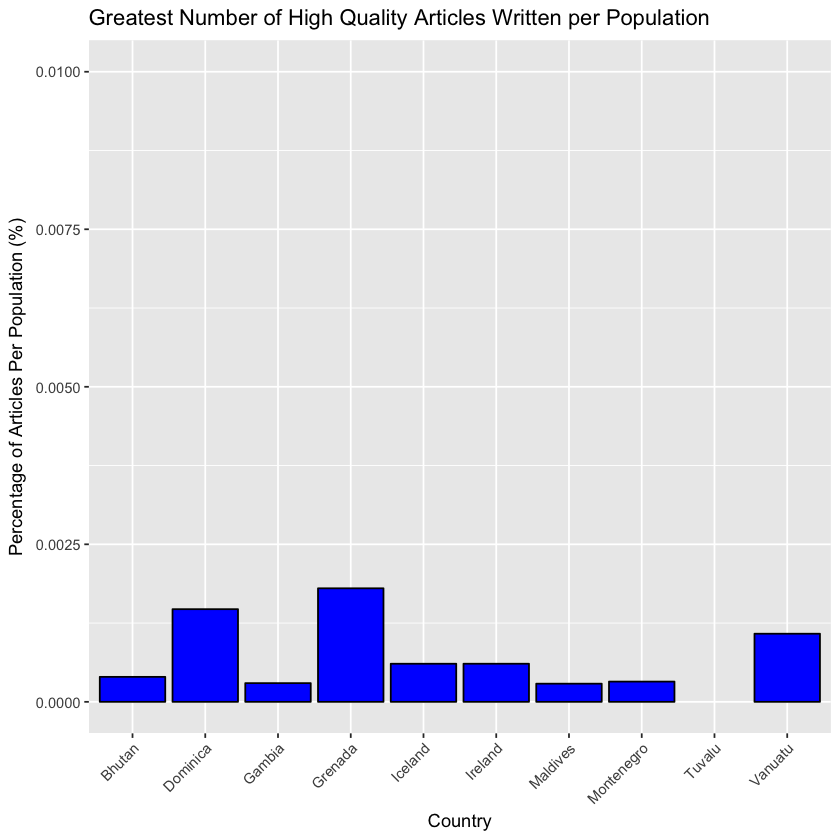

In [12]:
high_qual_articles <- ggplot(head(total_articles[order(total_articles$percenthigh, 
                                                       decreasing = T),],10), 
                             aes(country, percenthigh)) +
  geom_bar(stat = 'identity', color = 'black', fill='blue') +
  ylab('Percentage of Articles Per Population (%)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0,0.01)) +
  ggtitle('Greatest Number of High Quality Articles Written per Population') +
  xlab('Country')
png(file = 'top10_high_quality_articles.png')
plot(high_qual_articles)
dev.off()
high_qual_articles

pdf 
  2

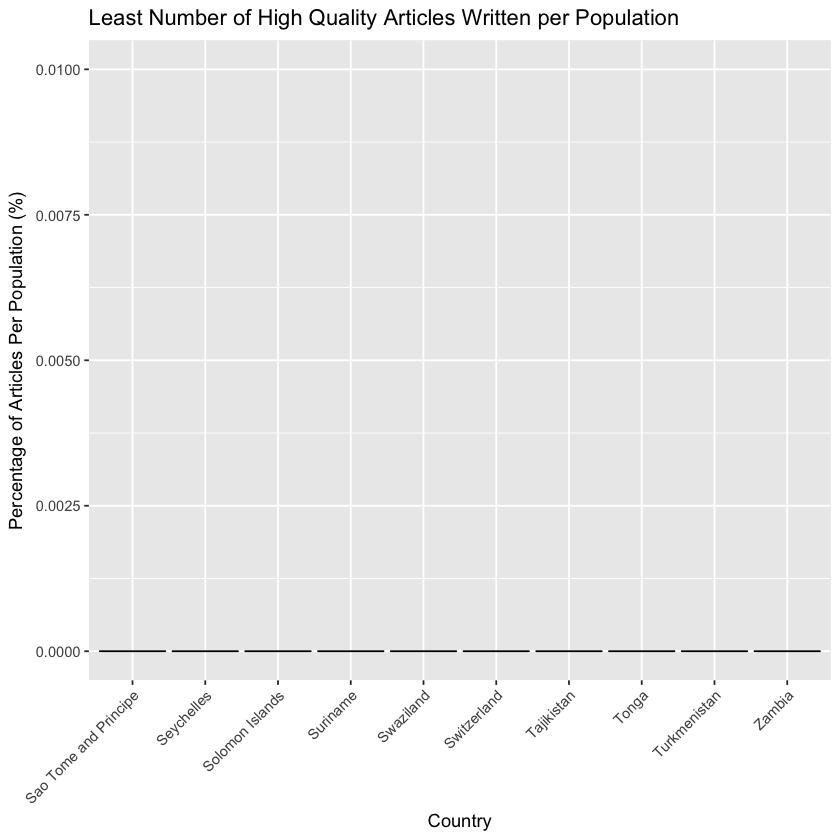

In [13]:
low_qual_articles <- ggplot(tail(total_articles[order(total_articles$percenthigh, 
                                                       decreasing = T),],10), 
                             aes(country, sort(percenthigh))) +
  geom_bar(stat = 'identity', color = 'black', fill='red') +
  ylab('Percentage of Articles Per Population (%)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0,0.01)) +
  ggtitle('Least Number of High Quality Articles Written per Population') +
  xlab('Country')
png(file = 'bottom10_high_quality_articles.png')
plot(low_qual_articles)
dev.off()
low_qual_articles